In [170]:
import pandas as pd
import numpy as np

file_path = "dna_methylation.csv"

dna_methylation = pd.read_csv(file_path, sep="\t")

# training set
training_set = (dna_methylation.Task == 'Training set')
training_set = dna_methylation[training_set]
training_data = training_set.iloc[:,4:].astype(float)
training_label = training_set["age"].values

print("Training data size")
print(training_data.shape)
print(training_label.shape)

# test set
test_set = (dna_methylation.Task == 'Test set')
test_set = dna_methylation[test_set]
test_data = test_set.iloc[:,4:].astype(float)
test_label = test_set["age"].values

print("")
print("Test data size")

print(test_data.shape)
print(test_label.shape)

Training data size
(208, 13)
(208,)

Test data size
(104, 13)
(104,)


Training for 10 experiment runs...
Root mean square score for train: 4.16
Root mean square score for test: 3.78


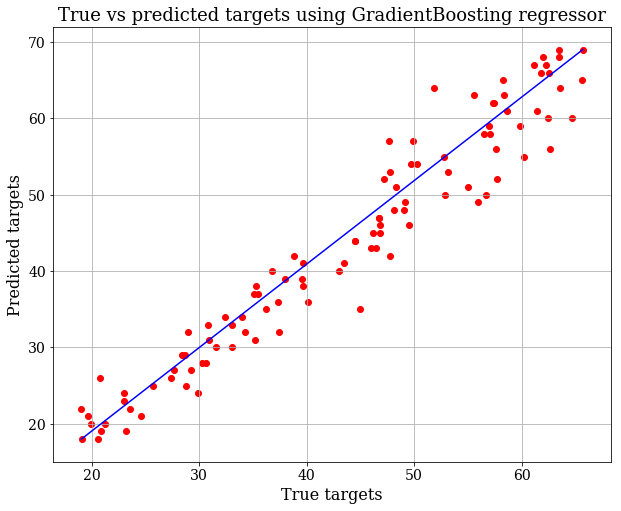

In [172]:
from sklearn import ensemble, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
import warnings
from matplotlib import pyplot as plt
from matplotlib import rcParams

warnings.filterwarnings('ignore')

rcParams['font.family'] = "serif"
cv = 10
rs = 3111696
exp_run = 10
rmse_train = np.zeros(exp_run)
rmse_test = np.zeros(exp_run)

# make sequential pipeline
regressor = Pipeline([
  ('regression', ensemble.GradientBoostingRegressor())
])

# list of possible parameter values to be checked 
parameters = [{ \
    'regression__n_estimators': [25, 50, 75, 100, 200]
}]

print("Training for %d experiment runs..." % exp_run)

# Mean squared error
mse = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

# Train GradientBoosting regressor
def train_gbr(experiment_number):

    # search for the best model
    optimized_regressor = GridSearchCV(regressor, parameters,
                                       cv=KFold(n_splits=cv, shuffle=True, random_state=rs),
                                       error_score=0, scoring=mse)

    # fit training data
    optimized_regressor.fit(training_data, training_label)
    best_regressor = optimized_regressor.best_estimator_

    # compute root mean squared error
    rmse_tr = np.sqrt(np.abs(optimized_regressor.best_score_))
    rmse_train[experiment_number] = rmse_tr

    # predict test data using the best model
    prediction = best_regressor.predict(test_data)
    rmse_te = np.sqrt(metrics.mean_squared_error(test_label.tolist(), prediction))
    rmse_test[experiment_number] = rmse_te

for item in range(exp_run):
    train_gbr(item)
    
print("Root mean square score for train: %.2f" % np.mean(rmse_train))
print("Root mean square score for test: %.2f" % np.mean(rmse_test))

# Plot true vs predicted targets
plt.figure(figsize=(10, 8))

# plot x = y line
x = [min(prediction), max(prediction)]
y = [min(test_label), max(test_label)]
plt.plot(x, y, c='b')

plt.scatter(prediction, test_label.tolist(), color='r')
plt.xlabel('True targets', size=16)
plt.ylabel('Predicted targets', size=16)
plt.title('True vs predicted targets using GradientBoosting regressor', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(True)
plt.show()